In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install scikit-learn

     |████████████████████████████████| 24.9 MB 7.0 MB/s eta 0:00:01     |██████████████████████████████▍ | 23.6 MB 7.0 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 27.2 MB 6.0 MB/s eta 0:00:01    |███▎                            | 2.8 MB 7.9 MB/s eta 0:00:04


In [221]:
import sys
sys.path.append('/tmp/myapp/src/')

In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import random, seed
import torch
import torch.nn as nn
from models import LSTM
from sklearn.preprocessing import MinMaxScaler

In [4]:
seed(42)

In [160]:
def generate_random(start = 100, n_steps = 350):
    out = [start]
    val = start
    for _ in range(n_steps):
        step = 2*random() - 1
        val = val + step
        out.append(val)
        
    return out

def generate_nonrandom(start = 100, n_steps = 350):
    out = []
    val = 0
    for _ in range(n_steps):
        step = 0.4
        val = val + step
        out.append(start + np.cos(np.cos(val)*np.cos(0.2*val) + 0.1*val)+0.02*val + 0.1*(2*random()-1))
        
    return out

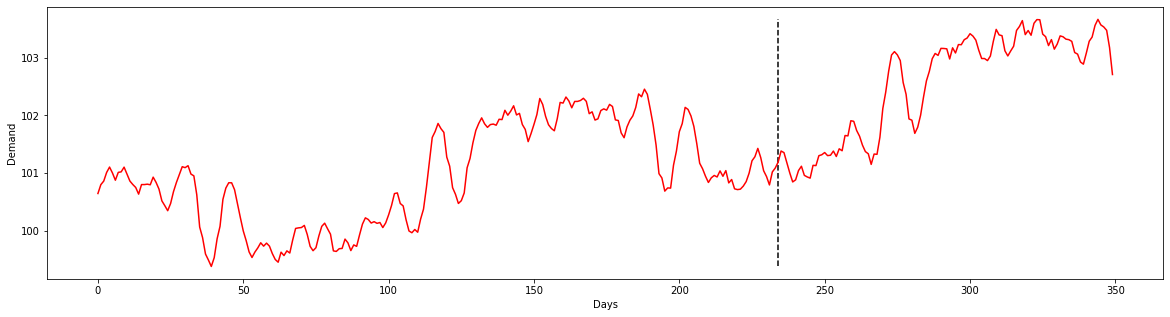

In [161]:
stocks_0 = generate_nonrandom()

fig = plt.figure(figsize=(20,5))
plt.plot(stocks_0,'r-')
plt.vlines(int(0.67*len(stocks_0)),np.min(stocks_0),np.max(stocks_0),linestyles = '--',colors = 'k')
plt.xlabel('Days')
plt.ylabel('Demand');

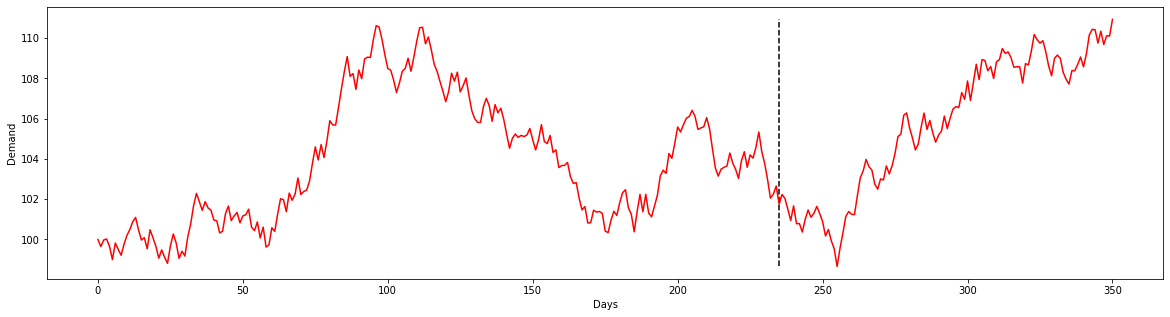

In [86]:
stocks = generate_random()

fig = plt.figure(figsize=(20,5))
plt.plot(stocks,'r-')
plt.vlines(int(0.67*len(stocks)),np.min(stocks),np.max(stocks),linestyles = '--',colors = 'k')
plt.xlabel('Days')
plt.ylabel('Demand');

In [215]:
training_set = pd.DataFrame(stocks)

def sliding_windows(data, seq_length, horison=1):
    x = []
    y = []

    for i in range(len(data)-seq_length-1 - (horison - 1)):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length + horison - 1]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length, 4)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [216]:
num_epochs = 10000
learning_rate = 0.001

input_size = 1
hidden_size = 4
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [217]:
# Train the model

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1000 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07693
Epoch: 1000, loss: 0.00928
Epoch: 2000, loss: 0.00879
Epoch: 3000, loss: 0.00852
Epoch: 4000, loss: 0.00838
Epoch: 5000, loss: 0.00742
Epoch: 6000, loss: 0.00697
Epoch: 7000, loss: 0.00650
Epoch: 8000, loss: 0.00607
Epoch: 9000, loss: 0.00586


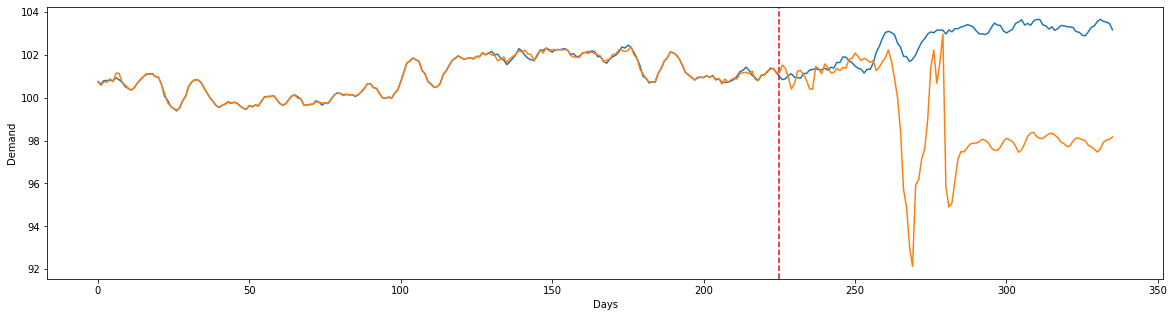

In [210]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize= (20,5))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
#plt.plot(range(231,len(data_predict)),data_predict[231:])
plt.plot(range(len(data_predict)),data_predict[:])
plt.xlabel('Days')
plt.ylabel('Demand');
plt.show()

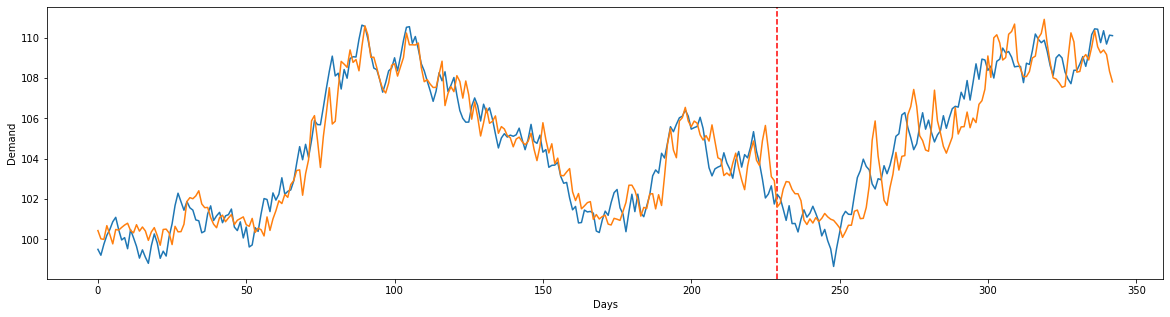

In [218]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize= (20,5))

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
#plt.plot(range(231,len(data_predict)),data_predict[231:])
plt.plot(range(len(data_predict)),data_predict[:])
plt.xlabel('Days')
plt.ylabel('Demand');